In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
#rcParams['figure.figsize'] = 15, 6



In [2]:
air_passengers = pd.read_csv("AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0) 
# log transform
log_air_passengers = np.log(air_passengers.Passengers)
# difference
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()
# drop Nan
log_air_passengers_diff.dropna(inplace=True)

# 一阶差分后得到平稳的时间序列:特征不随时间而变化，就称此过程是平稳的。


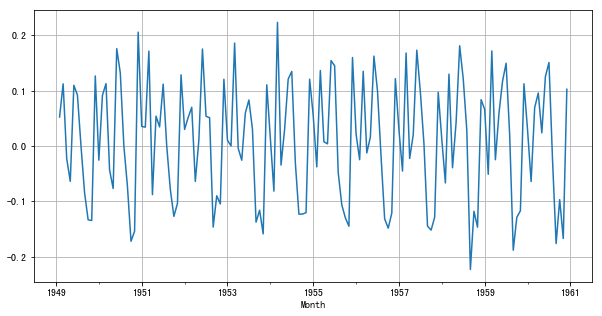

In [3]:
log_air_passengers_diff.plot(figsize=(10, 5), grid=True)


ARIMA Model

ARIMA模型全称为自回归积分滑动平均模型(Autoregressive Integrated Moving Average Model,简记ARIMA)，其中ARIMA（p，d，q）称为差分自回归移动平均模型.

AR是自回归
p为自回归项 Auto-Regressive Terms §
MA为移动平均
q为移动平均项数 Moving Average Terms (q)
d为时间序列成为平稳时所做的差分次数

ARIMA模型预测的基本程序

根据时间序列的可视化结果对序列的平稳性进行识别。
对非平稳序列进行平稳化处理。如果数据序列是非平稳的，并存在一定的增长或下降趋势，则需要对数据进行差分处理.
根据时间序列模型的识别规则，建立相应的模型。若平稳序列的偏相关函数是截尾的，而自相关函数是拖尾的，可断定序列适合AR模型；若平稳序列的偏相关函数是拖尾的，而自相关函数是截尾的，则可断定序列适合MA模型；若平稳序列的偏相关函数和自相关函数均是拖尾的，则序列适合ARMA模型.(截尾是指时间序列的自相关函数（ACF）或偏自相关函数（PACF）在某阶后均为0的性质（比如AR的PACF）；拖尾是ACF或PACF并不在某阶后均为0的性质)
进行参数估计，检验是否具有统计意义。
进行假设检验，诊断残差序列是否为白噪声。
利用已通过检验的模型进行预测分析。


In [4]:
# ARIAM的参数从数据中获得, 计算平稳时间序列的自相关和偏自相关函数值
from statsmodels.tsa.stattools import acf, pacf
lag_acf, acf_confint= acf(log_air_passengers_diff.values, nlags = 20, alpha=0.05)   
# alpha=0.05,返回95%的置信边界
lag_pacf, pacf_confint = pacf(log_air_passengers_diff.values, nlags = 20, alpha=0.05)

In [5]:
ave_acf_confint = np.mean(acf_confint,axis=0)
ave_pacf_confint = np.mean(pacf_confint,axis=0)

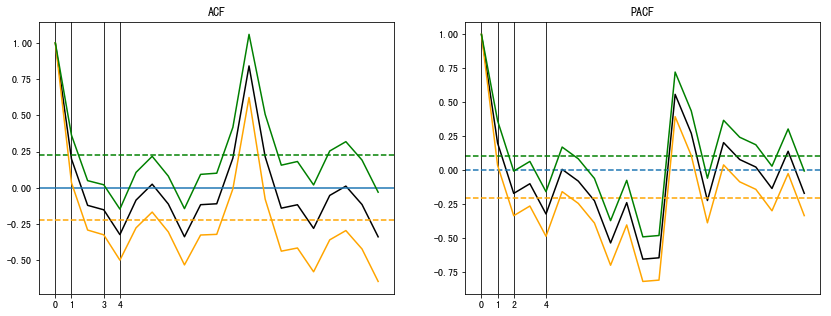

In [6]:
plt.figure(figsize=(14,5))
plt.subplot(121) 
plt.plot(lag_acf,c='k')
plt.axhline(y=0,linestyle='-')
plt.axhline(ave_acf_confint[0],linestyle='--',c='orange')
plt.axhline(ave_acf_confint[1],linestyle='--',c='green')
plt.plot(acf_confint[:,0],c='orange')
plt.plot(acf_confint[:,1],c='green')
plt.grid(True, axis='x', linestyle='-', c='k')
plt.xticks([0, 1, 3, 4])
plt.title('ACF')
#-------------------------------------------
plt.subplot(122) 
plt.plot(lag_pacf,c='k')
plt.axhline(y=0,linestyle='--')
plt.axhline(ave_pacf_confint[0],linestyle='--',c='orange')
plt.axhline(ave_pacf_confint[1],linestyle='--',c='green')
plt.plot(pacf_confint[:,0],c='orange')
plt.plot(pacf_confint[:,1],c='green')
plt.xticks([0, 1, 2, 4])
plt.grid(True, axis='x', linestyle='-', c='k')
plt.title('PACF')

自相关图显示滞后0,1阶都是拖尾

偏自相关图显示滞后0,2,4阶拖尾

P,Q的取值可以尝试多个不同的组合.来确定最佳的参数



In [7]:

# AR model
from statsmodels.tsa.arima_model import ARIMA



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


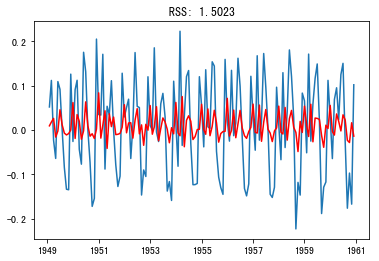

In [8]:
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))



Text(0.5,1,'RSS: 1.5023')



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


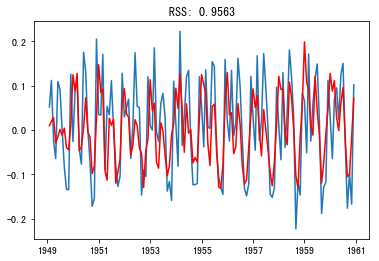

In [10]:
# ARIMA model
model = ARIMA(log_air_passengers, order=(2, 1, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))



Text(0.5,1,'RSS: 0.9661')


Predict feature



In [11]:
def predict_value(seed, pred_diff):
    prev_value = seed
    pred_value = []
    for diff in pred_diff:
        pred_log = prev_value + diff
        pred_value.append(pred_log)
        prev_value = pred_log
    return pred_value    



In [12]:
predictions_arima_diff = results_ARIMA.predict(1,157).tolist()



In [13]:
seed_1 = log_air_passengers.tolist()[0]
seed_2 = log_air_passengers.tolist()[-1]



In [14]:
pred_log1 = predict_value(seed_1, predictions_arima_diff)

pred_log1 = [seed_1] + pred_log1



In [15]:
pred_log2 = predict_value(seed_2, predictions_arima_diff[143:])

pred_log2 = log_air_passengers.tolist()+pred_log2



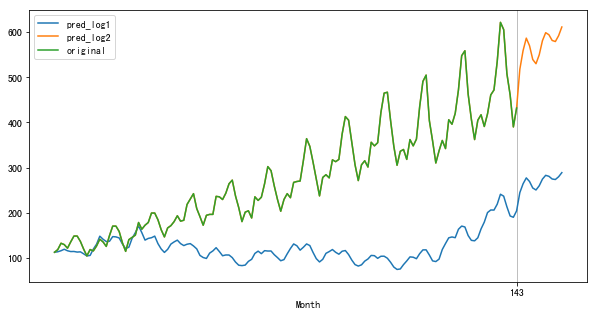

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(np.exp(pred_log1),label='pred_log1')
plt.plot(np.exp(pred_log2),label='pred_log2')
plt.plot(air_passengers.values,label='original')
plt.legend()
plt.grid(True, axis='x')
plt.xticks([143])
plt.xlabel('Month')

